# PyTorch GAN Implementations


Implementations of key Generative Adversarial Network variants:

1. **Vanilla GAN** — Goodfellow et al., 2014
2. **DCGAN** — Radford et al., 2016
3. **Conditional GAN** — Mirza & Osindero, 2014
4. **Wasserstein GAN** — Arjovsky et al., 2017
5. **WGAN-GP** — Gulrajani et al., 2017
6. **LSGAN** — Mao et al., 2017
7. **InfoGAN** — Chen et al., 2016
8. **Adversarial Autoencoder** — Makhzani et al., 2016

All trained on MNIST for easy comparison.

## Imports & Utilities

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1


In [2]:
# Shared hyperparameters
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 28
BATCH_SIZE = 64
LR = 0.0002
BETAS = (0.5, 0.999)
EPOCHS = 20

# MNIST DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"Dataset size: {len(mnist_dataset)}")
print(f"Batches per epoch: {len(dataloader)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.61MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.51MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.07MB/s]

Dataset size: 60000
Batches per epoch: 937


In [3]:
def show_images(images, nrow=10, title="Generated Images"):
    """Display a grid of generated images."""
    images = images.detach().cpu()
    images = (images + 1) / 2  # Denormalize from [-1,1] to [0,1]
    grid = make_grid(images[:nrow*nrow], nrow=nrow, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def weights_init_normal(m):
    """Initialize weights with normal distribution."""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("Linear") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

def plot_losses(g_losses, d_losses, title="Training Losses"):
    """Plot generator and discriminator losses."""
    plt.figure(figsize=(10, 4))
    plt.plot(g_losses, label='Generator', alpha=0.7)
    plt.plot(d_losses, label='Discriminator', alpha=0.7)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

---
# 1. Vanilla GAN

*Generative Adversarial Networks* — Goodfellow et al., 2014

The original GAN: a Generator and Discriminator play a minimax game.
The Generator maps random noise to images, while the Discriminator classifies real vs. fake.

$$\min_G \max_D \; \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$

In [4]:
class VanillaGenerator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(IMG_SHAPE))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), *IMG_SHAPE)


class VanillaDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [5]:
# Train Vanilla GAN
G_van = VanillaGenerator().to(device)
D_van = VanillaDiscriminator().to(device)

optimizer_G = optim.Adam(G_van.parameters(), lr=LR, betas=BETAS)
optimizer_D = optim.Adam(D_van.parameters(), lr=LR, betas=BETAS)
adversarial_loss = nn.BCELoss()

g_losses_van, d_losses_van = [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real = imgs.to(device)
        valid = torch.ones(BATCH_SIZE, 1, device=device)
        fake_label = torch.zeros(BATCH_SIZE, 1, device=device)

        # --- Train Generator ---
        optimizer_G.zero_grad()
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_imgs = G_van(z)
        g_loss = adversarial_loss(D_van(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(D_van(real), valid)
        fake_loss = adversarial_loss(D_van(gen_imgs.detach()), fake_label)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        g_losses_van.append(g_loss.item())
        d_losses_van.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] D loss: {d_loss.item():.4f} G loss: {g_loss.item():.4f}")

print("Vanilla GAN training complete!")

[Epoch 1/20] D loss: 0.5058 G loss: 0.7453
[Epoch 2/20] D loss: 0.5269 G loss: 0.7897
[Epoch 3/20] D loss: 0.4284 G loss: 1.0827
[Epoch 4/20] D loss: 0.5626 G loss: 1.7643
[Epoch 5/20] D loss: 0.4825 G loss: 0.7399
[Epoch 6/20] D loss: 0.5314 G loss: 1.7704
[Epoch 7/20] D loss: 0.5293 G loss: 0.9205
[Epoch 8/20] D loss: 0.5566 G loss: 0.8934
[Epoch 9/20] D loss: 0.5522 G loss: 0.7644
[Epoch 10/20] D loss: 0.5287 G loss: 1.0881
[Epoch 11/20] D loss: 0.6154 G loss: 1.1321
[Epoch 12/20] D loss: 0.6572 G loss: 1.0096
[Epoch 13/20] D loss: 0.6151 G loss: 0.6622
[Epoch 14/20] D loss: 0.5917 G loss: 1.1369
[Epoch 15/20] D loss: 0.5899 G loss: 1.1439
[Epoch 16/20] D loss: 0.6040 G loss: 0.6420
[Epoch 17/20] D loss: 0.6254 G loss: 0.6641
[Epoch 18/20] D loss: 0.6642 G loss: 1.5569
[Epoch 19/20] D loss: 0.6527 G loss: 0.6285
[Epoch 20/20] D loss: 0.5932 G loss: 1.0028
Vanilla GAN training complete!


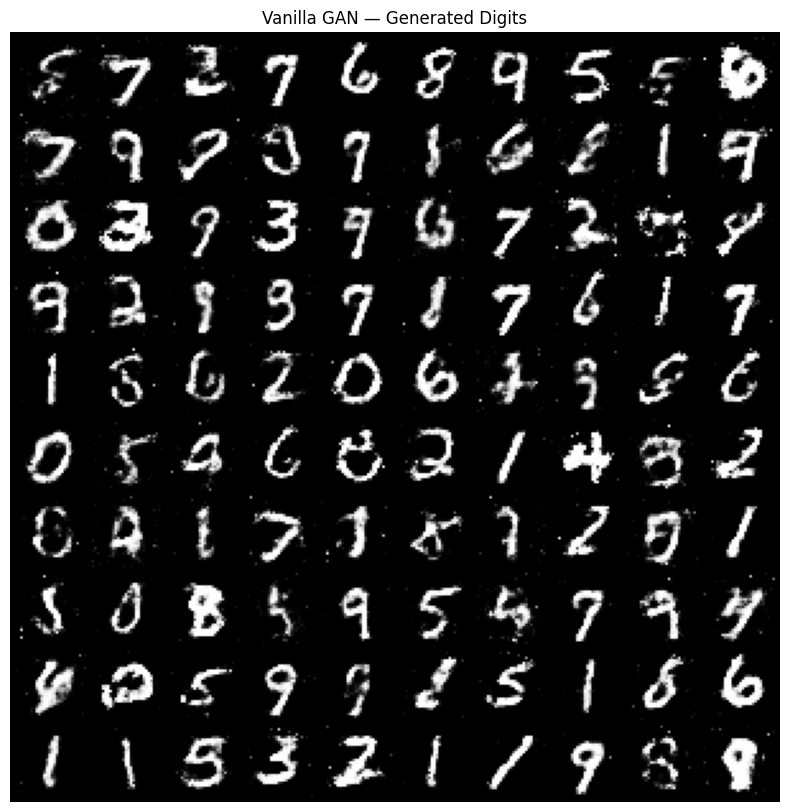

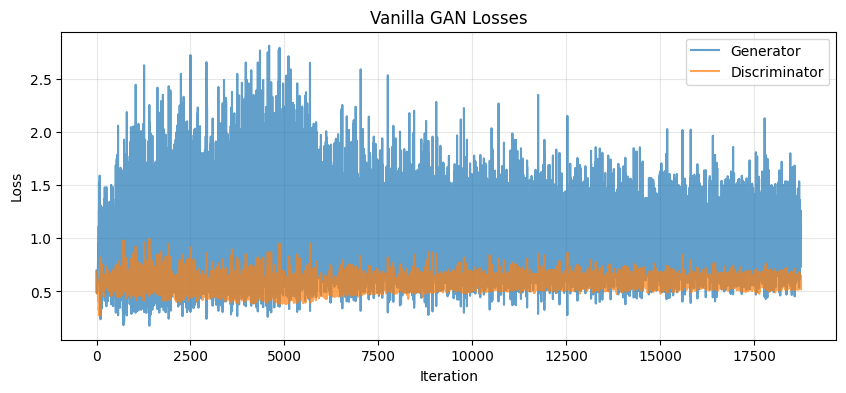

In [6]:
z = torch.randn(100, LATENT_DIM, device=device)
with torch.no_grad():
    gen_imgs = G_van(z)
show_images(gen_imgs, title="Vanilla GAN — Generated Digits")
plot_losses(g_losses_van, d_losses_van, "Vanilla GAN Losses")

---
# 2. Deep Convolutional GAN (DCGAN)

*Unsupervised Representation Learning with Deep Convolutional GANs* — Radford et al., 2016

Key architectural guidelines:
- Replace pooling with strided convolutions (D) and fractional-strided convolutions (G)
- Use BatchNorm in both G and D
- Remove fully connected hidden layers
- Use ReLU in G (except output: Tanh), LeakyReLU in D

In [9]:
class DCGenerator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.init_size = IMG_SIZE // 4  # 7
        self.fc = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        return self.conv_blocks(out)


class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_ch, out_ch, bn=True):
            layers = [nn.Conv2d(in_ch, out_ch, 3, 2, 1),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Dropout2d(0.25)]
            if bn:
                layers.append(nn.BatchNorm2d(out_ch))
            return layers

        self.model = nn.Sequential(
            *block(1, 16, bn=False),
            *block(16, 32),
            *block(32, 64),
            *block(64, 128),
        )

        # Compute actual flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, IMG_SIZE, IMG_SIZE)
            dummy_out = self.model(dummy)
            self.flat_size = int(np.prod(dummy_out.shape[1:]))

        self.adv_layer = nn.Sequential(nn.Linear(self.flat_size, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.size(0), -1)
        return self.adv_layer(out)

In [10]:
# Train DCGAN
G_dc = DCGenerator().to(device)
D_dc = DCDiscriminator().to(device)
G_dc.apply(weights_init_normal)
D_dc.apply(weights_init_normal)

optimizer_G = optim.Adam(G_dc.parameters(), lr=LR, betas=BETAS)
optimizer_D = optim.Adam(D_dc.parameters(), lr=LR, betas=BETAS)
adversarial_loss = nn.BCELoss()

g_losses_dc, d_losses_dc = [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real = imgs.to(device)
        valid = torch.ones(BATCH_SIZE, 1, device=device)
        fake_label = torch.zeros(BATCH_SIZE, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_imgs = G_dc(z)
        g_loss = adversarial_loss(D_dc(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        d_loss = (adversarial_loss(D_dc(real), valid) +
                  adversarial_loss(D_dc(gen_imgs.detach()), fake_label)) / 2
        d_loss.backward()
        optimizer_D.step()

        g_losses_dc.append(g_loss.item())
        d_losses_dc.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] D loss: {d_loss.item():.4f} G loss: {g_loss.item():.4f}")

print("DCGAN training complete!")

[Epoch 1/20] D loss: 0.6229 G loss: 0.8054
[Epoch 2/20] D loss: 0.6310 G loss: 0.8405
[Epoch 3/20] D loss: 0.5381 G loss: 0.8924
[Epoch 4/20] D loss: 0.3258 G loss: 1.4965
[Epoch 5/20] D loss: 0.5389 G loss: 0.7928
[Epoch 6/20] D loss: 0.5448 G loss: 2.0076
[Epoch 7/20] D loss: 0.3412 G loss: 2.5342
[Epoch 8/20] D loss: 0.3743 G loss: 0.2967
[Epoch 9/20] D loss: 0.2971 G loss: 1.3356
[Epoch 10/20] D loss: 0.3317 G loss: 1.4438
[Epoch 11/20] D loss: 0.2406 G loss: 1.5343
[Epoch 12/20] D loss: 0.3072 G loss: 0.9645
[Epoch 13/20] D loss: 0.1341 G loss: 2.4508
[Epoch 14/20] D loss: 0.1063 G loss: 2.6086
[Epoch 15/20] D loss: 0.1394 G loss: 4.3170
[Epoch 16/20] D loss: 0.2580 G loss: 1.4097
[Epoch 17/20] D loss: 0.2546 G loss: 3.0776
[Epoch 18/20] D loss: 0.1373 G loss: 1.0238
[Epoch 19/20] D loss: 0.1602 G loss: 1.8236
[Epoch 20/20] D loss: 0.2121 G loss: 2.3710
DCGAN training complete!


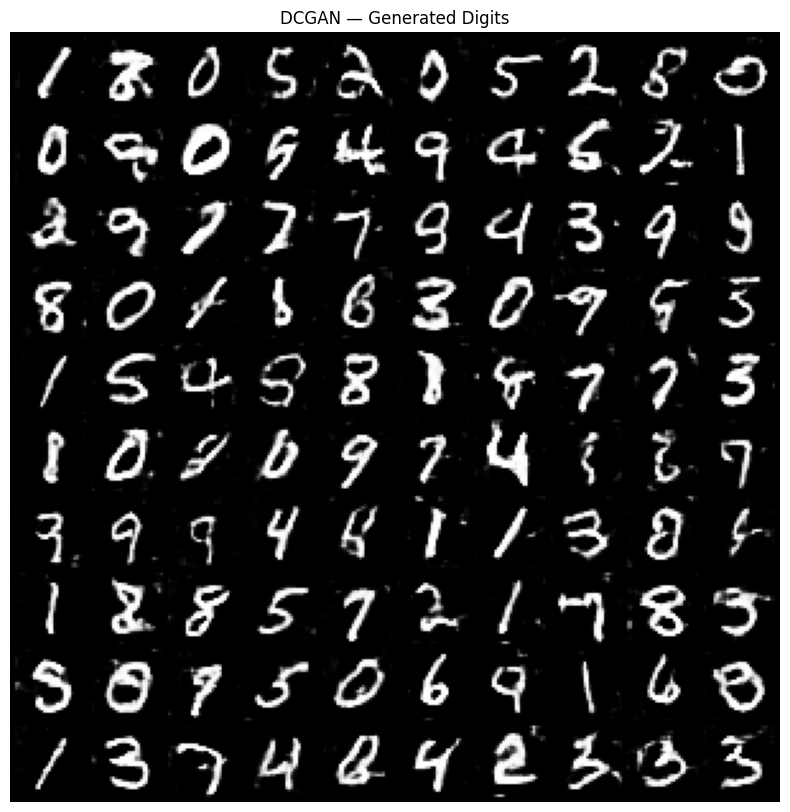

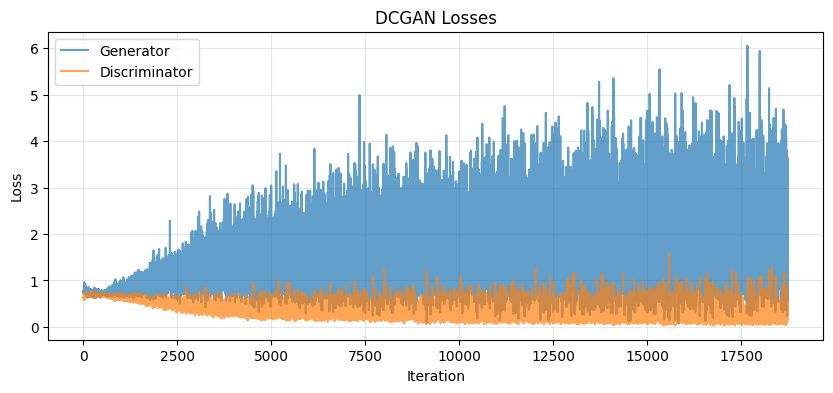

In [11]:
z = torch.randn(100, LATENT_DIM, device=device)
with torch.no_grad():
    gen_imgs = G_dc(z)
show_images(gen_imgs, title="DCGAN — Generated Digits")
plot_losses(g_losses_dc, d_losses_dc, "DCGAN Losses")

---
# 3. Conditional GAN (cGAN)

*Conditional Generative Adversarial Nets* — Mirza & Osindero, 2014

Both Generator and Discriminator are conditioned on class labels, enabling
generation of images from specific classes.

In [12]:
N_CLASSES = 10

class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, n_classes=N_CLASSES):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(IMG_SHAPE))),
            nn.Tanh()
        )

    def forward(self, z, labels):
        gen_input = torch.cat([z, self.label_emb(labels)], dim=1)
        img = self.model(gen_input)
        return img.view(img.size(0), *IMG_SHAPE)


class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes=N_CLASSES):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)) + n_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat([img.view(img.size(0), -1), self.label_emb(labels)], dim=1)
        return self.model(d_in)

In [13]:
# Train Conditional GAN
G_cgan = ConditionalGenerator().to(device)
D_cgan = ConditionalDiscriminator().to(device)

optimizer_G = optim.Adam(G_cgan.parameters(), lr=LR, betas=BETAS)
optimizer_D = optim.Adam(D_cgan.parameters(), lr=LR, betas=BETAS)
adversarial_loss = nn.BCELoss()

g_losses_cgan, d_losses_cgan = [], []

for epoch in range(EPOCHS):
    for i, (imgs, labels) in enumerate(dataloader):
        real = imgs.to(device)
        labels = labels.to(device)
        valid = torch.ones(BATCH_SIZE, 1, device=device)
        fake_label = torch.zeros(BATCH_SIZE, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_labels = torch.randint(0, N_CLASSES, (BATCH_SIZE,), device=device)
        gen_imgs = G_cgan(z, gen_labels)
        g_loss = adversarial_loss(D_cgan(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(D_cgan(real, labels), valid)
        fake_loss = adversarial_loss(D_cgan(gen_imgs.detach(), gen_labels), fake_label)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        g_losses_cgan.append(g_loss.item())
        d_losses_cgan.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] D loss: {d_loss.item():.4f} G loss: {g_loss.item():.4f}")

print("Conditional GAN training complete!")

[Epoch 1/20] D loss: 0.3712 G loss: 1.5484
[Epoch 2/20] D loss: 0.4931 G loss: 1.5796
[Epoch 3/20] D loss: 0.7942 G loss: 0.3765
[Epoch 4/20] D loss: 0.4472 G loss: 1.0698
[Epoch 5/20] D loss: 0.4806 G loss: 1.1800
[Epoch 6/20] D loss: 0.5222 G loss: 0.8744
[Epoch 7/20] D loss: 0.5454 G loss: 1.4090
[Epoch 8/20] D loss: 0.6280 G loss: 0.9586
[Epoch 9/20] D loss: 0.6343 G loss: 1.1470
[Epoch 10/20] D loss: 0.5662 G loss: 0.8027
[Epoch 11/20] D loss: 0.5773 G loss: 1.2516
[Epoch 12/20] D loss: 0.5756 G loss: 0.8247
[Epoch 13/20] D loss: 0.6194 G loss: 0.7379
[Epoch 14/20] D loss: 0.5914 G loss: 1.0284
[Epoch 15/20] D loss: 0.6314 G loss: 1.0127
[Epoch 16/20] D loss: 0.6851 G loss: 0.7487
[Epoch 17/20] D loss: 0.6561 G loss: 0.7337
[Epoch 18/20] D loss: 0.6528 G loss: 0.8274
[Epoch 19/20] D loss: 0.6526 G loss: 0.8136
[Epoch 20/20] D loss: 0.6518 G loss: 0.7589
Conditional GAN training complete!


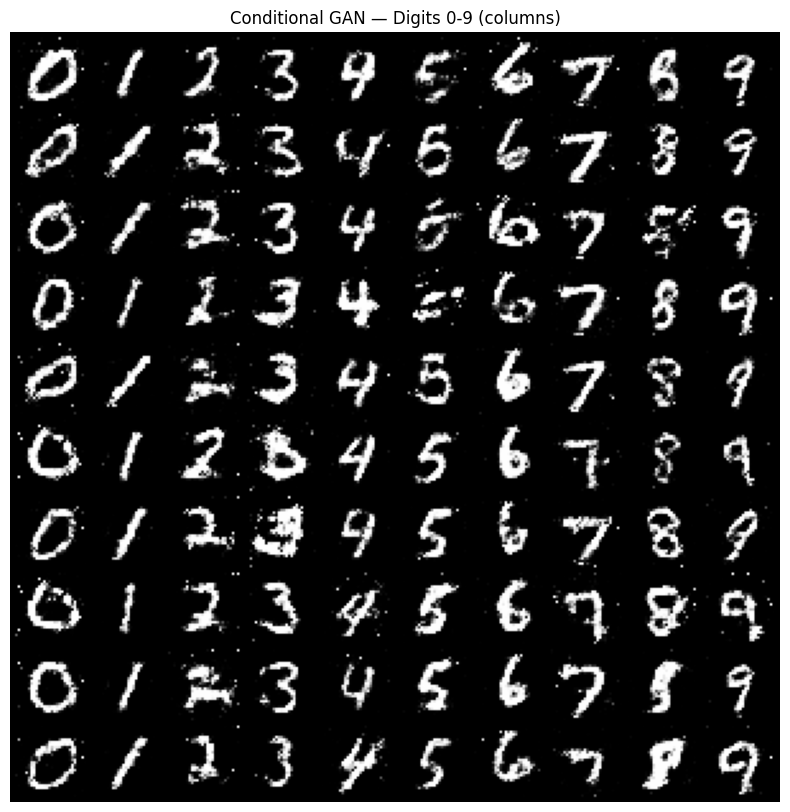

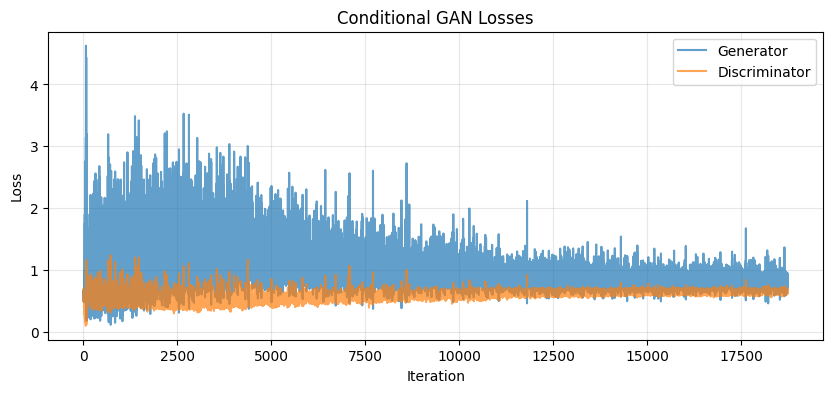

In [14]:
# Generate each digit 0-9
z = torch.randn(100, LATENT_DIM, device=device)
labels = torch.arange(10, device=device).repeat(10)  # 10 rows, each digit repeated
with torch.no_grad():
    gen_imgs = G_cgan(z, labels)
show_images(gen_imgs, nrow=10, title="Conditional GAN — Digits 0-9 (columns)")
plot_losses(g_losses_cgan, d_losses_cgan, "Conditional GAN Losses")

---
# 4. Wasserstein GAN (WGAN)

*Wasserstein GAN* — Arjovsky et al., 2017

Replaces the JS divergence with the Earth-Mover (Wasserstein-1) distance.
- No sigmoid in discriminator (now called "critic")
- Weight clipping to enforce Lipschitz constraint
- More stable training and meaningful loss curves

In [15]:
class WGANGenerator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(IMG_SHAPE))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), *IMG_SHAPE)


class WGANCritic(nn.Module):
    """No sigmoid — outputs unbounded score."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)  # No sigmoid!
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

In [16]:
# Train WGAN
CLIP_VALUE = 0.01
N_CRITIC = 5  # Train critic more than generator

G_wgan = WGANGenerator().to(device)
C_wgan = WGANCritic().to(device)

optimizer_G = optim.RMSprop(G_wgan.parameters(), lr=5e-5)
optimizer_C = optim.RMSprop(C_wgan.parameters(), lr=5e-5)

g_losses_wgan, d_losses_wgan = [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real = imgs.to(device)

        # --- Train Critic ---
        optimizer_C.zero_grad()
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        fake_imgs = G_wgan(z).detach()
        # Wasserstein loss: maximize E[C(real)] - E[C(fake)]
        c_loss = -torch.mean(C_wgan(real)) + torch.mean(C_wgan(fake_imgs))
        c_loss.backward()
        optimizer_C.step()

        # Weight clipping
        for p in C_wgan.parameters():
            p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)

        # Train Generator every N_CRITIC steps
        if i % N_CRITIC == 0:
            optimizer_G.zero_grad()
            gen_imgs = G_wgan(z)
            g_loss = -torch.mean(C_wgan(gen_imgs))
            g_loss.backward()
            optimizer_G.step()

            g_losses_wgan.append(g_loss.item())

        d_losses_wgan.append(c_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] C loss: {c_loss.item():.4f} G loss: {g_loss.item():.4f}")

print("WGAN training complete!")

[Epoch 1/20] C loss: -0.0344 G loss: -11.3314
[Epoch 2/20] C loss: -0.0108 G loss: -9.4759
[Epoch 3/20] C loss: -0.0215 G loss: -7.2769
[Epoch 4/20] C loss: -0.0149 G loss: -5.9791
[Epoch 5/20] C loss: -0.0216 G loss: -4.4740
[Epoch 6/20] C loss: 0.0016 G loss: -3.2457
[Epoch 7/20] C loss: -0.0274 G loss: -2.2573
[Epoch 8/20] C loss: -0.0019 G loss: -1.7191
[Epoch 9/20] C loss: -0.0291 G loss: -0.9581
[Epoch 10/20] C loss: -0.0480 G loss: -0.5340
[Epoch 11/20] C loss: -0.0571 G loss: -0.3296
[Epoch 12/20] C loss: -0.0687 G loss: -0.2548
[Epoch 13/20] C loss: -0.0918 G loss: -0.2482
[Epoch 14/20] C loss: -0.0819 G loss: -0.4808
[Epoch 15/20] C loss: -0.0710 G loss: -0.4565
[Epoch 16/20] C loss: -0.0633 G loss: -0.3448
[Epoch 17/20] C loss: -0.0698 G loss: -0.3187
[Epoch 18/20] C loss: -0.0693 G loss: -0.2603
[Epoch 19/20] C loss: -0.0628 G loss: -0.2527
[Epoch 20/20] C loss: -0.0626 G loss: -0.3128
WGAN training complete!


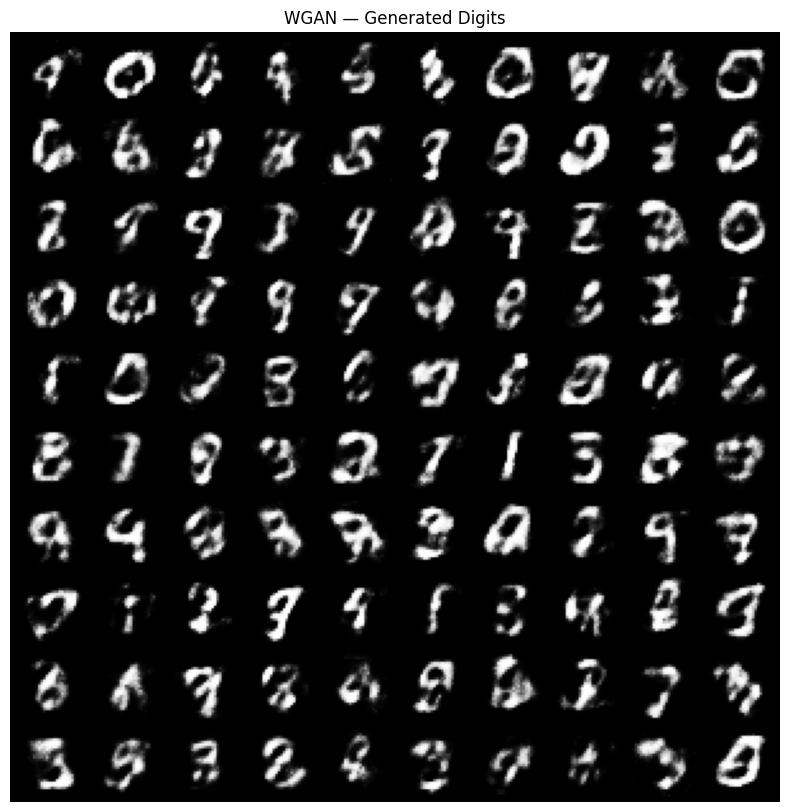

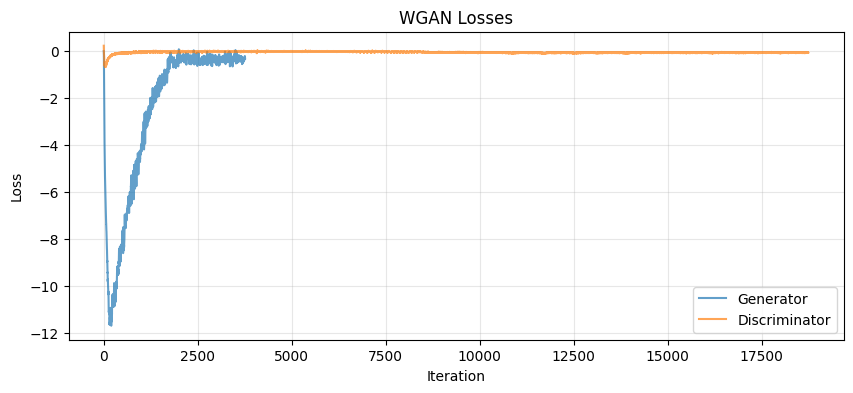

In [17]:
z = torch.randn(100, LATENT_DIM, device=device)
with torch.no_grad():
    gen_imgs = G_wgan(z)
show_images(gen_imgs, title="WGAN — Generated Digits")
plot_losses(g_losses_wgan, d_losses_wgan, "WGAN Losses")

---
# 5. Wasserstein GAN with Gradient Penalty (WGAN-GP)

*Improved Training of Wasserstein GANs* — Gulrajani et al., 2017

Replaces weight clipping with a gradient penalty to enforce the Lipschitz constraint.
Much more stable and avoids capacity underuse caused by clipping.

$$\mathcal{L}_{GP} = \lambda \; \mathbb{E}_{\hat{x}}[(||\nabla_{\hat{x}} D(\hat{x})||_2 - 1)^2]$$

In [18]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Compute gradient penalty for WGAN-GP."""
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [19]:
# WGAN-GP uses same generator, but critic without BatchNorm
class WGPCritic(nn.Module):
    """Critic without BatchNorm (incompatible with gradient penalty)."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

In [20]:
# Train WGAN-GP
LAMBDA_GP = 10
N_CRITIC = 5

G_wgp = WGANGenerator().to(device)
C_wgp = WGPCritic().to(device)

optimizer_G = optim.Adam(G_wgp.parameters(), lr=1e-4, betas=(0.0, 0.9))
optimizer_C = optim.Adam(C_wgp.parameters(), lr=1e-4, betas=(0.0, 0.9))

g_losses_wgp, d_losses_wgp = [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real = imgs.to(device)

        # Train Critic
        optimizer_C.zero_grad()
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        fake_imgs = G_wgp(z).detach()
        gp = compute_gradient_penalty(C_wgp, real, fake_imgs)
        c_loss = -torch.mean(C_wgp(real)) + torch.mean(C_wgp(fake_imgs)) + LAMBDA_GP * gp
        c_loss.backward()
        optimizer_C.step()

        if i % N_CRITIC == 0:
            optimizer_G.zero_grad()
            gen_imgs = G_wgp(z)
            g_loss = -torch.mean(C_wgp(gen_imgs))
            g_loss.backward()
            optimizer_G.step()

            g_losses_wgp.append(g_loss.item())

        d_losses_wgp.append(c_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] C loss: {c_loss.item():.4f} G loss: {g_loss.item():.4f}")

print("WGAN-GP training complete!")

[Epoch 1/20] C loss: -0.2432 G loss: -16.2223
[Epoch 2/20] C loss: -4.6801 G loss: -3.3097
[Epoch 3/20] C loss: -3.6454 G loss: -4.4011
[Epoch 4/20] C loss: -3.0928 G loss: -4.0367
[Epoch 5/20] C loss: -3.1411 G loss: -4.2013
[Epoch 6/20] C loss: -2.5313 G loss: -5.7576
[Epoch 7/20] C loss: -2.6558 G loss: -4.1814
[Epoch 8/20] C loss: -2.6840 G loss: -4.3667
[Epoch 9/20] C loss: -1.9800 G loss: -5.7141
[Epoch 10/20] C loss: -2.0956 G loss: -6.8508
[Epoch 11/20] C loss: -1.9901 G loss: -5.5297
[Epoch 12/20] C loss: -1.8269 G loss: -7.0474
[Epoch 13/20] C loss: -1.6833 G loss: -4.5043
[Epoch 14/20] C loss: -1.6372 G loss: -5.0666
[Epoch 15/20] C loss: -1.4971 G loss: -4.4162
[Epoch 16/20] C loss: -1.7639 G loss: -5.5838
[Epoch 17/20] C loss: -1.6289 G loss: -5.9316
[Epoch 18/20] C loss: -1.2796 G loss: -7.0574
[Epoch 19/20] C loss: -1.3904 G loss: -7.0094
[Epoch 20/20] C loss: -1.3460 G loss: -5.5269
WGAN-GP training complete!


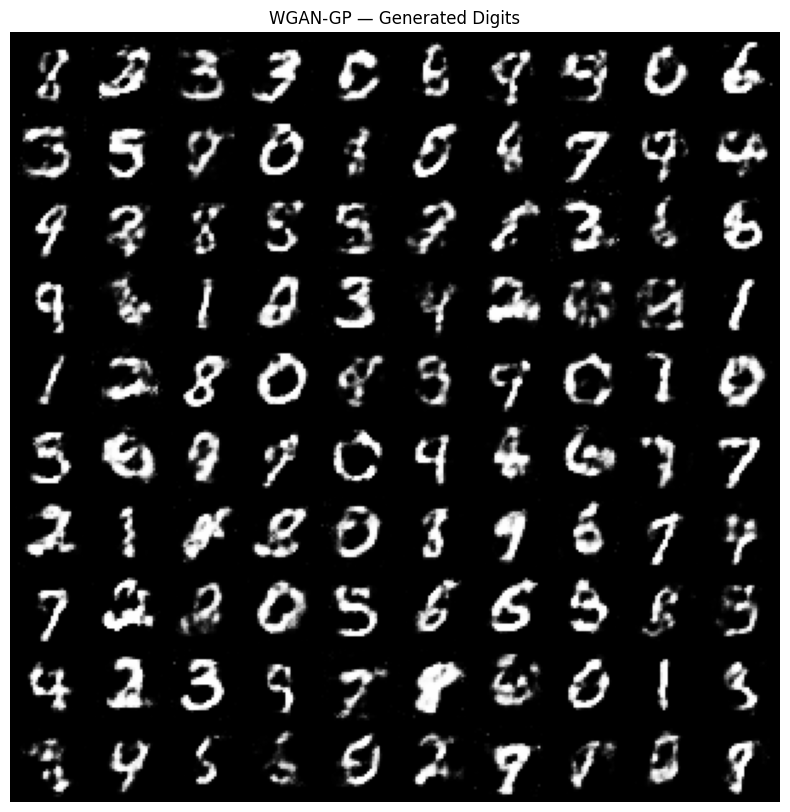

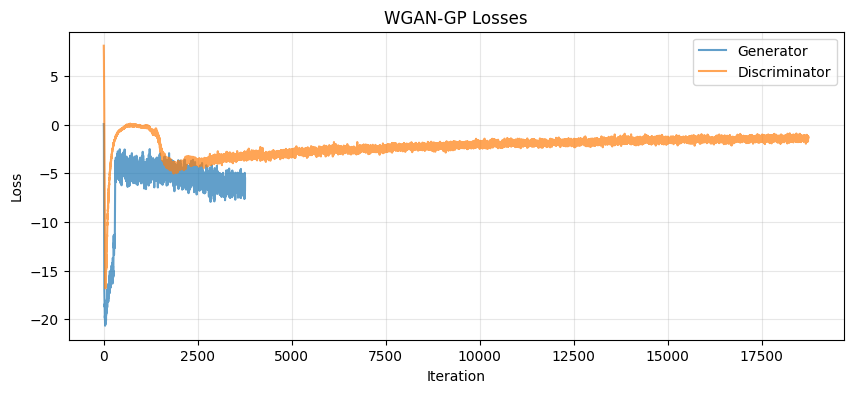

In [21]:
z = torch.randn(100, LATENT_DIM, device=device)
with torch.no_grad():
    gen_imgs = G_wgp(z)
show_images(gen_imgs, title="WGAN-GP — Generated Digits")
plot_losses(g_losses_wgp, d_losses_wgp, "WGAN-GP Losses")

---
# 6. Least Squares GAN (LSGAN)

*Least Squares Generative Adversarial Networks* — Mao et al., 2017

Replaces BCE loss with MSE loss to avoid vanishing gradients and generate higher quality images.

$$\mathcal{L}_D = \frac{1}{2}\mathbb{E}[(D(x)-1)^2] + \frac{1}{2}\mathbb{E}[D(G(z))^2]$$

$$\mathcal{L}_G = \frac{1}{2}\mathbb{E}[(D(G(z))-1)^2]$$

In [22]:
class LSDiscriminator(nn.Module):
    """No sigmoid — uses MSE loss instead of BCE."""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)  # No sigmoid
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

In [23]:
# Train LSGAN (reuses VanillaGenerator)
G_ls = VanillaGenerator().to(device)
D_ls = LSDiscriminator().to(device)

optimizer_G = optim.Adam(G_ls.parameters(), lr=LR, betas=BETAS)
optimizer_D = optim.Adam(D_ls.parameters(), lr=LR, betas=BETAS)
mse_loss = nn.MSELoss()

g_losses_ls, d_losses_ls = [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real = imgs.to(device)
        valid = torch.ones(BATCH_SIZE, 1, device=device)
        fake_label = torch.zeros(BATCH_SIZE, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        gen_imgs = G_ls(z)
        g_loss = mse_loss(D_ls(gen_imgs), valid)  # Fool discriminator
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = mse_loss(D_ls(real), valid)
        fake_loss = mse_loss(D_ls(gen_imgs.detach()), fake_label)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        g_losses_ls.append(g_loss.item())
        d_losses_ls.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] D loss: {d_loss.item():.4f} G loss: {g_loss.item():.4f}")

print("LSGAN training complete!")

[Epoch 1/20] D loss: 0.1601 G loss: 0.3065
[Epoch 2/20] D loss: 0.1413 G loss: 0.5349
[Epoch 3/20] D loss: 0.1309 G loss: 0.4733
[Epoch 4/20] D loss: 0.1967 G loss: 0.4259
[Epoch 5/20] D loss: 0.1924 G loss: 0.2645
[Epoch 6/20] D loss: 0.1842 G loss: 0.4618
[Epoch 7/20] D loss: 0.1555 G loss: 0.4357
[Epoch 8/20] D loss: 0.1987 G loss: 0.3319
[Epoch 9/20] D loss: 0.1759 G loss: 0.5376
[Epoch 10/20] D loss: 0.1870 G loss: 0.4233
[Epoch 11/20] D loss: 0.1884 G loss: 0.3398
[Epoch 12/20] D loss: 0.1811 G loss: 0.4605
[Epoch 13/20] D loss: 0.1866 G loss: 0.3723
[Epoch 14/20] D loss: 0.1840 G loss: 0.4006
[Epoch 15/20] D loss: 0.2151 G loss: 0.2721
[Epoch 16/20] D loss: 0.2292 G loss: 0.2976
[Epoch 17/20] D loss: 0.2217 G loss: 0.3990
[Epoch 18/20] D loss: 0.2021 G loss: 0.3355
[Epoch 19/20] D loss: 0.1827 G loss: 0.4638
[Epoch 20/20] D loss: 0.2202 G loss: 0.5053
LSGAN training complete!


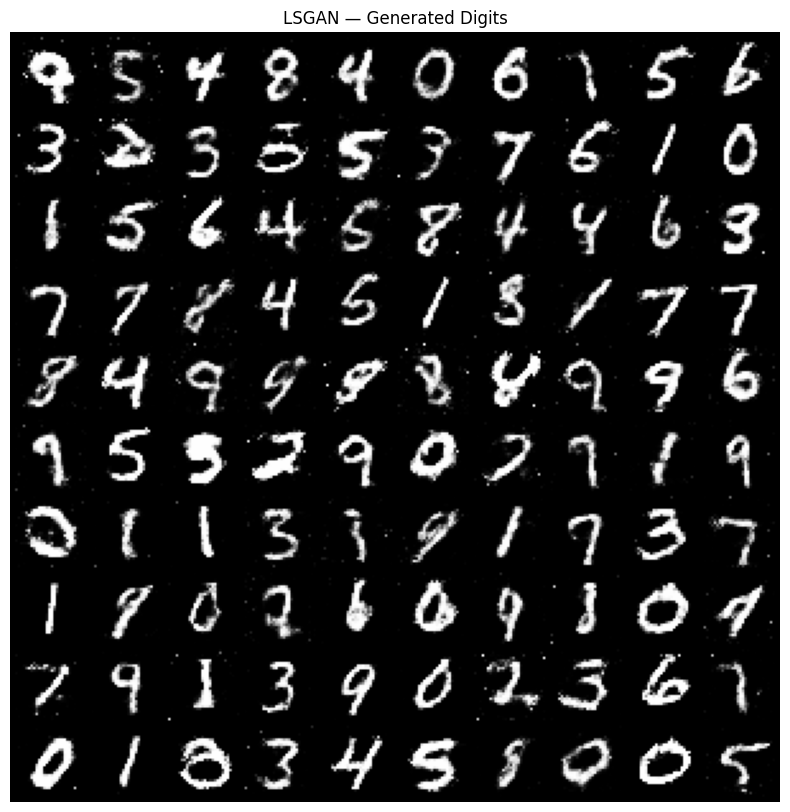

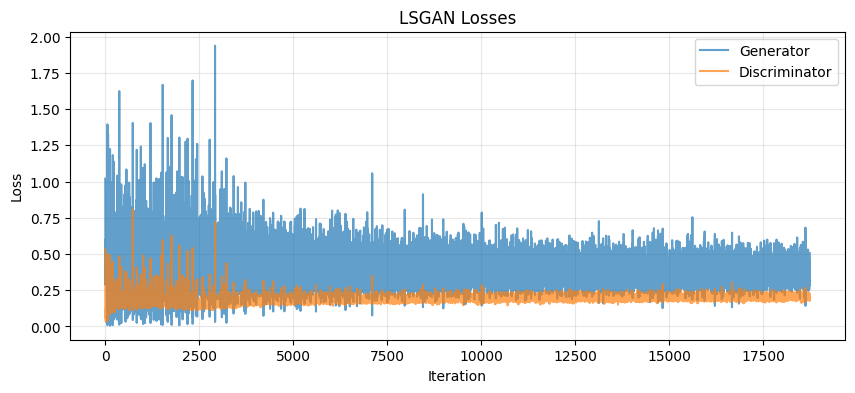

In [24]:
z = torch.randn(100, LATENT_DIM, device=device)
with torch.no_grad():
    gen_imgs = G_ls(z)
show_images(gen_imgs, title="LSGAN — Generated Digits")
plot_losses(g_losses_ls, d_losses_ls, "LSGAN Losses")

---
# 7. InfoGAN

*InfoGAN: Interpretable Representation Learning* — Chen et al., 2016

Maximizes mutual information between a subset of latent variables (codes) and
the generated output. This forces the generator to use the codes in a
semantically meaningful way (e.g., digit identity, style, rotation).

Latent space = noise `z` + categorical code `c_cat` + continuous codes `c_cont`

In [25]:
N_CLASSES_INFO = 10
CODE_DIM = 2  # Continuous latent codes

class InfoGenerator(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, n_classes=N_CLASSES_INFO, code_dim=CODE_DIM):
        super().__init__()
        input_dim = latent_dim + n_classes + code_dim

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(np.prod(IMG_SHAPE))),
            nn.Tanh()
        )

    def forward(self, z, c_cat, c_cont):
        gen_input = torch.cat([z, c_cat, c_cont], dim=1)
        img = self.model(gen_input)
        return img.view(img.size(0), *IMG_SHAPE)


class InfoDiscriminator(nn.Module):
    def __init__(self, n_classes=N_CLASSES_INFO, code_dim=CODE_DIM):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Adversarial head
        self.adv_head = nn.Sequential(nn.Linear(256, 1), nn.Sigmoid())
        # Q-network heads (auxiliary: recover latent codes)
        self.q_cat = nn.Sequential(nn.Linear(256, n_classes))  # Categorical logits
        self.q_cont = nn.Sequential(nn.Linear(256, code_dim))  # Continuous means

    def forward(self, img):
        features = self.shared(img.view(img.size(0), -1))
        validity = self.adv_head(features)
        cat_pred = self.q_cat(features)
        cont_pred = self.q_cont(features)
        return validity, cat_pred, cont_pred

In [26]:
# Train InfoGAN
LAMBDA_CAT = 1.0
LAMBDA_CONT = 0.1

G_info = InfoGenerator().to(device)
D_info = InfoDiscriminator().to(device)

optimizer_G = optim.Adam(
    list(G_info.parameters()) + list(D_info.q_cat.parameters()) + list(D_info.q_cont.parameters()),
    lr=LR, betas=BETAS
)
optimizer_D = optim.Adam(
    list(D_info.shared.parameters()) + list(D_info.adv_head.parameters()),
    lr=LR, betas=BETAS
)

adversarial_loss = nn.BCELoss()
categorical_loss = nn.CrossEntropyLoss()
continuous_loss = nn.MSELoss()

g_losses_info, d_losses_info = [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real = imgs.to(device)
        valid = torch.ones(BATCH_SIZE, 1, device=device)
        fake_label = torch.zeros(BATCH_SIZE, 1, device=device)

        # Sample noise and codes
        z = torch.randn(BATCH_SIZE, LATENT_DIM, device=device)
        c_cat_idx = torch.randint(0, N_CLASSES_INFO, (BATCH_SIZE,), device=device)
        c_cat = F.one_hot(c_cat_idx, N_CLASSES_INFO).float()
        c_cont = torch.randn(BATCH_SIZE, CODE_DIM, device=device) * 0.5

        # Train Discriminator
        optimizer_D.zero_grad()
        gen_imgs = G_info(z, c_cat, c_cont).detach()
        real_pred, _, _ = D_info(real)
        fake_pred, _, _ = D_info(gen_imgs)
        d_loss = (adversarial_loss(real_pred, valid) + adversarial_loss(fake_pred, fake_label)) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator + Info loss
        optimizer_G.zero_grad()
        gen_imgs = G_info(z, c_cat, c_cont)
        validity, cat_pred, cont_pred = D_info(gen_imgs)
        g_adv = adversarial_loss(validity, valid)
        info_cat = categorical_loss(cat_pred, c_cat_idx)
        info_cont = continuous_loss(cont_pred, c_cont)
        g_loss = g_adv + LAMBDA_CAT * info_cat + LAMBDA_CONT * info_cont
        g_loss.backward()
        optimizer_G.step()

        g_losses_info.append(g_loss.item())
        d_losses_info.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] D: {d_loss.item():.4f} G: {g_loss.item():.4f} "
          f"Cat: {info_cat.item():.4f} Cont: {info_cont.item():.4f}")

print("InfoGAN training complete!")

[Epoch 1/20] D: 0.5318 G: 1.4645 Cat: 0.3338 Cont: 0.2319
[Epoch 2/20] D: 0.5120 G: 0.9853 Cat: 0.1389 Cont: 0.2899
[Epoch 3/20] D: 0.5050 G: 1.9115 Cat: 0.0926 Cont: 0.2194
[Epoch 4/20] D: 0.5411 G: 1.5253 Cat: 0.0755 Cont: 0.2646
[Epoch 5/20] D: 0.9228 G: 0.4561 Cat: 0.0948 Cont: 0.2213
[Epoch 6/20] D: 0.5356 G: 1.0724 Cat: 0.0700 Cont: 0.2547
[Epoch 7/20] D: 0.5902 G: 1.5872 Cat: 0.0480 Cont: 0.2624
[Epoch 8/20] D: 0.6005 G: 0.7604 Cat: 0.0462 Cont: 0.3075
[Epoch 9/20] D: 0.5930 G: 1.9565 Cat: 0.0353 Cont: 0.2755
[Epoch 10/20] D: 0.5068 G: 1.8816 Cat: 0.0148 Cont: 0.2439
[Epoch 11/20] D: 0.5853 G: 2.7168 Cat: 0.0327 Cont: 0.2515
[Epoch 12/20] D: 0.5080 G: 1.1190 Cat: 0.0946 Cont: 0.2401
[Epoch 13/20] D: 0.5690 G: 1.9359 Cat: 0.0322 Cont: 0.2810
[Epoch 14/20] D: 0.4584 G: 1.0867 Cat: 0.0266 Cont: 0.2905
[Epoch 15/20] D: 0.5469 G: 0.8929 Cat: 0.0420 Cont: 0.2221
[Epoch 16/20] D: 0.6612 G: 2.3483 Cat: 0.0578 Cont: 0.2341
[Epoch 17/20] D: 0.5524 G: 1.8827 Cat: 0.0654 Cont: 0.2144
[Epoch

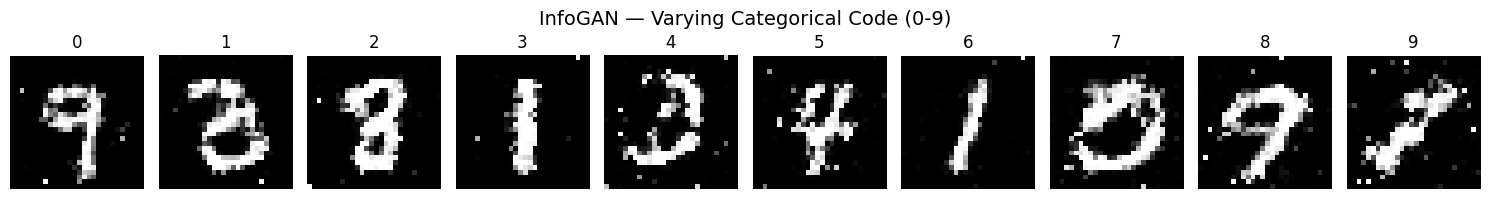

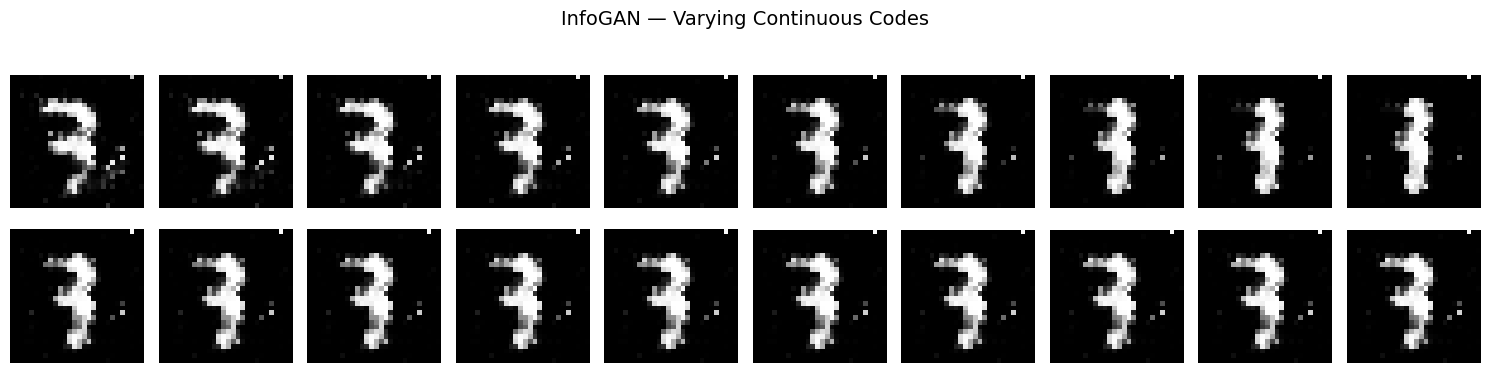

In [29]:
# Set to eval mode for single-sample inference
G_info.eval()

# Vary categorical code (digit identity)
z_fixed = torch.randn(1, LATENT_DIM, device=device).repeat(10, 1)
c_cont_fixed = torch.zeros(10, CODE_DIM, device=device)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("InfoGAN — Varying Categorical Code (0-9)", fontsize=14)
for digit in range(10):
    c_cat = F.one_hot(torch.tensor([digit], device=device), N_CLASSES_INFO).float()
    with torch.no_grad():
        img = G_info(z_fixed[:1], c_cat, c_cont_fixed[:1])
    img = (img.cpu().squeeze() + 1) / 2
    axes[digit].imshow(img, cmap='gray')
    axes[digit].set_title(str(digit))
    axes[digit].axis('off')
plt.tight_layout()
plt.show()

# Vary continuous code
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
fig.suptitle("InfoGAN — Varying Continuous Codes", fontsize=14)
z_fixed = torch.randn(1, LATENT_DIM, device=device)
c_cat_fixed = F.one_hot(torch.tensor([3], device=device), N_CLASSES_INFO).float()

for code_idx in range(2):
    values = torch.linspace(-2, 2, 10)
    for j, val in enumerate(values):
        c_cont = torch.zeros(1, CODE_DIM, device=device)
        c_cont[0, code_idx] = val
        with torch.no_grad():
            img = G_info(z_fixed, c_cat_fixed, c_cont)
        img = (img.cpu().squeeze() + 1) / 2
        axes[code_idx][j].imshow(img, cmap='gray')
        axes[code_idx][j].axis('off')
    axes[code_idx][0].set_ylabel(f'c{code_idx+1}', fontsize=12, rotation=0, labelpad=20)
plt.tight_layout()
plt.show()

# Set back to train mode if needed later
G_info.train();

---
# 8. Adversarial Autoencoder (AAE)

*Adversarial Autoencoders* — Makhzani et al., 2016

Uses a GAN to match the aggregated posterior of the encoder's latent space to an
arbitrary prior distribution (e.g., Gaussian). Combines the reconstruction quality
of autoencoders with the generative power of GANs.

In [30]:
AAE_LATENT_DIM = 10

class Encoder(nn.Module):
    def __init__(self, latent_dim=AAE_LATENT_DIM):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(IMG_SHAPE)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

    def forward(self, img):
        x = self.model(img.view(img.size(0), -1))
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mu, logvar)
        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


class Decoder(nn.Module):
    def __init__(self, latent_dim=AAE_LATENT_DIM):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(np.prod(IMG_SHAPE))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), *IMG_SHAPE)


class LatentDiscriminator(nn.Module):
    """Discriminates between real prior samples and encoder outputs."""
    def __init__(self, latent_dim=AAE_LATENT_DIM):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

In [31]:
# Train Adversarial Autoencoder
encoder = Encoder().to(device)
decoder = Decoder().to(device)
D_aae = LatentDiscriminator().to(device)

optimizer_AE = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()), lr=LR, betas=BETAS
)
optimizer_D = optim.Adam(D_aae.parameters(), lr=LR, betas=BETAS)
optimizer_G_enc = optim.Adam(encoder.parameters(), lr=LR, betas=BETAS)

recon_loss_fn = nn.MSELoss()
adversarial_loss = nn.BCELoss()

ae_losses, g_losses_aae, d_losses_aae = [], [], []

for epoch in range(EPOCHS):
    for i, (imgs, _) in enumerate(dataloader):
        real = imgs.to(device)
        valid = torch.ones(BATCH_SIZE, 1, device=device)
        fake_label = torch.zeros(BATCH_SIZE, 1, device=device)

        # --- Phase 1: Reconstruction ---
        optimizer_AE.zero_grad()
        z_encoded = encoder(real)
        decoded = decoder(z_encoded)
        ae_loss = recon_loss_fn(decoded, real)
        ae_loss.backward()
        optimizer_AE.step()

        # --- Phase 2: Train latent discriminator ---
        optimizer_D.zero_grad()
        z_real = torch.randn(BATCH_SIZE, AAE_LATENT_DIM, device=device)  # Prior
        z_fake = encoder(real).detach()
        d_loss = (adversarial_loss(D_aae(z_real), valid) +
                  adversarial_loss(D_aae(z_fake), fake_label)) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Phase 3: Train encoder as generator ---
        optimizer_G_enc.zero_grad()
        z_fake = encoder(real)
        g_loss = adversarial_loss(D_aae(z_fake), valid)
        g_loss.backward()
        optimizer_G_enc.step()

        ae_losses.append(ae_loss.item())
        g_losses_aae.append(g_loss.item())
        d_losses_aae.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{EPOCHS}] AE: {ae_loss.item():.4f} "
          f"D: {d_loss.item():.4f} G: {g_loss.item():.4f}")

print("Adversarial Autoencoder training complete!")

[Epoch 1/20] AE: 0.1086 D: 0.6901 G: 0.7175
[Epoch 2/20] AE: 0.0888 D: 0.6911 G: 0.7215
[Epoch 3/20] AE: 0.0891 D: 0.6920 G: 0.7188
[Epoch 4/20] AE: 0.0913 D: 0.6905 G: 0.6986
[Epoch 5/20] AE: 0.0858 D: 0.6909 G: 0.7234
[Epoch 6/20] AE: 0.0880 D: 0.6907 G: 0.6896
[Epoch 7/20] AE: 0.0941 D: 0.6940 G: 0.6974
[Epoch 8/20] AE: 0.0913 D: 0.6946 G: 0.6921
[Epoch 9/20] AE: 0.0891 D: 0.6940 G: 0.7123
[Epoch 10/20] AE: 0.0861 D: 0.6913 G: 0.6935
[Epoch 11/20] AE: 0.0865 D: 0.6978 G: 0.7043
[Epoch 12/20] AE: 0.0893 D: 0.6915 G: 0.7134
[Epoch 13/20] AE: 0.0802 D: 0.6985 G: 0.6783
[Epoch 14/20] AE: 0.0901 D: 0.6931 G: 0.7198
[Epoch 15/20] AE: 0.0775 D: 0.6922 G: 0.7077
[Epoch 16/20] AE: 0.0755 D: 0.6960 G: 0.6903
[Epoch 17/20] AE: 0.0912 D: 0.6949 G: 0.7151
[Epoch 18/20] AE: 0.0788 D: 0.6936 G: 0.6992
[Epoch 19/20] AE: 0.0897 D: 0.6921 G: 0.6940
[Epoch 20/20] AE: 0.0883 D: 0.6916 G: 0.6787
Adversarial Autoencoder training complete!


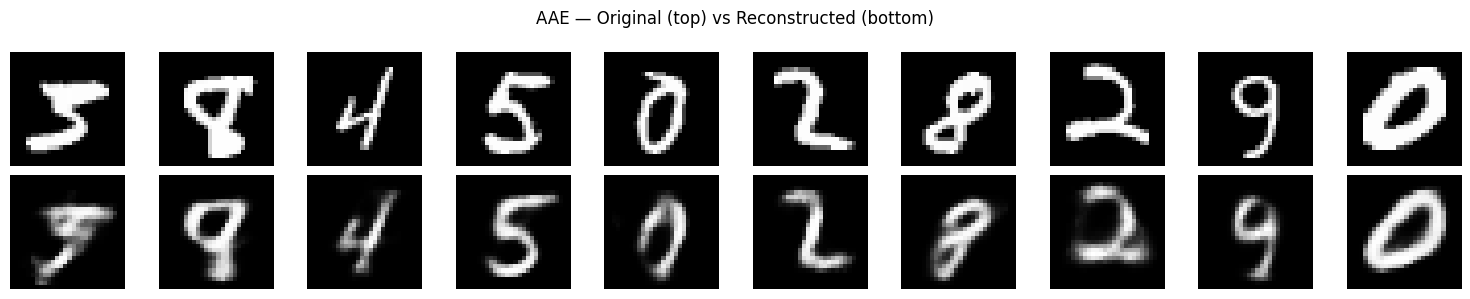

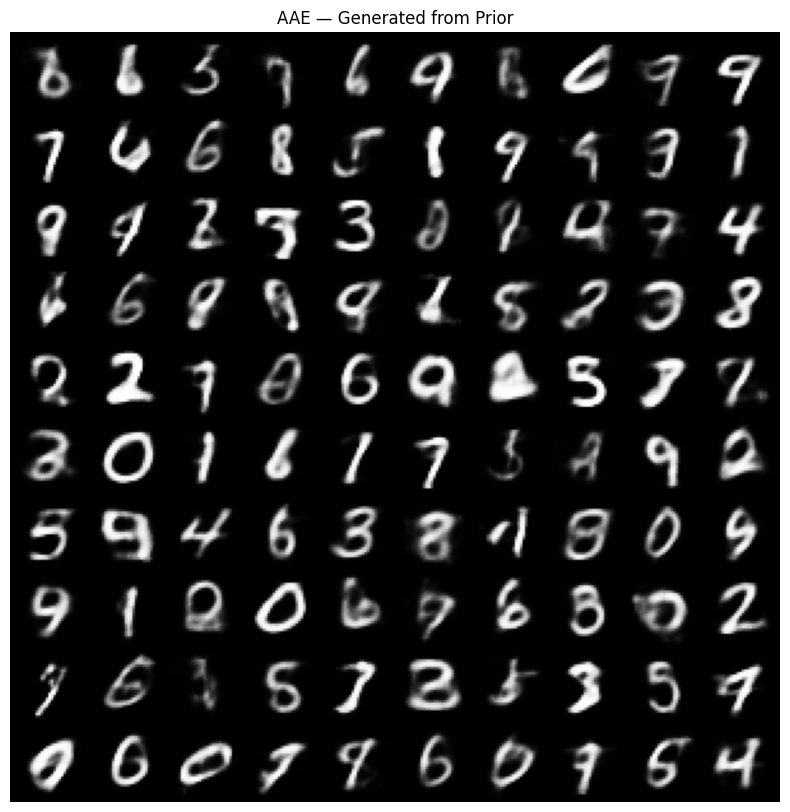

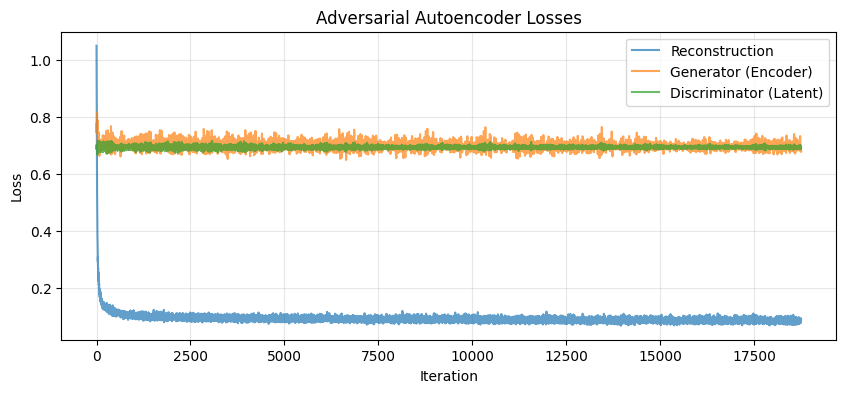

In [32]:
# Show reconstructions
with torch.no_grad():
    test_imgs = next(iter(dataloader))[0][:10].to(device)
    z = encoder(test_imgs)
    recon = decoder(z)

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle("AAE — Original (top) vs Reconstructed (bottom)")
for i in range(10):
    axes[0][i].imshow((test_imgs[i].cpu().squeeze() + 1) / 2, cmap='gray')
    axes[0][i].axis('off')
    axes[1][i].imshow((recon[i].cpu().squeeze() + 1) / 2, cmap='gray')
    axes[1][i].axis('off')
plt.tight_layout()
plt.show()

# Generate from prior
z = torch.randn(100, AAE_LATENT_DIM, device=device)
with torch.no_grad():
    gen_imgs = decoder(z)
show_images(gen_imgs, title="AAE — Generated from Prior")

# Plot losses
plt.figure(figsize=(10, 4))
plt.plot(ae_losses, label='Reconstruction', alpha=0.7)
plt.plot(g_losses_aae, label='Generator (Encoder)', alpha=0.7)
plt.plot(d_losses_aae, label='Discriminator (Latent)', alpha=0.7)
plt.title('Adversarial Autoencoder Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
# Comparison & Summary

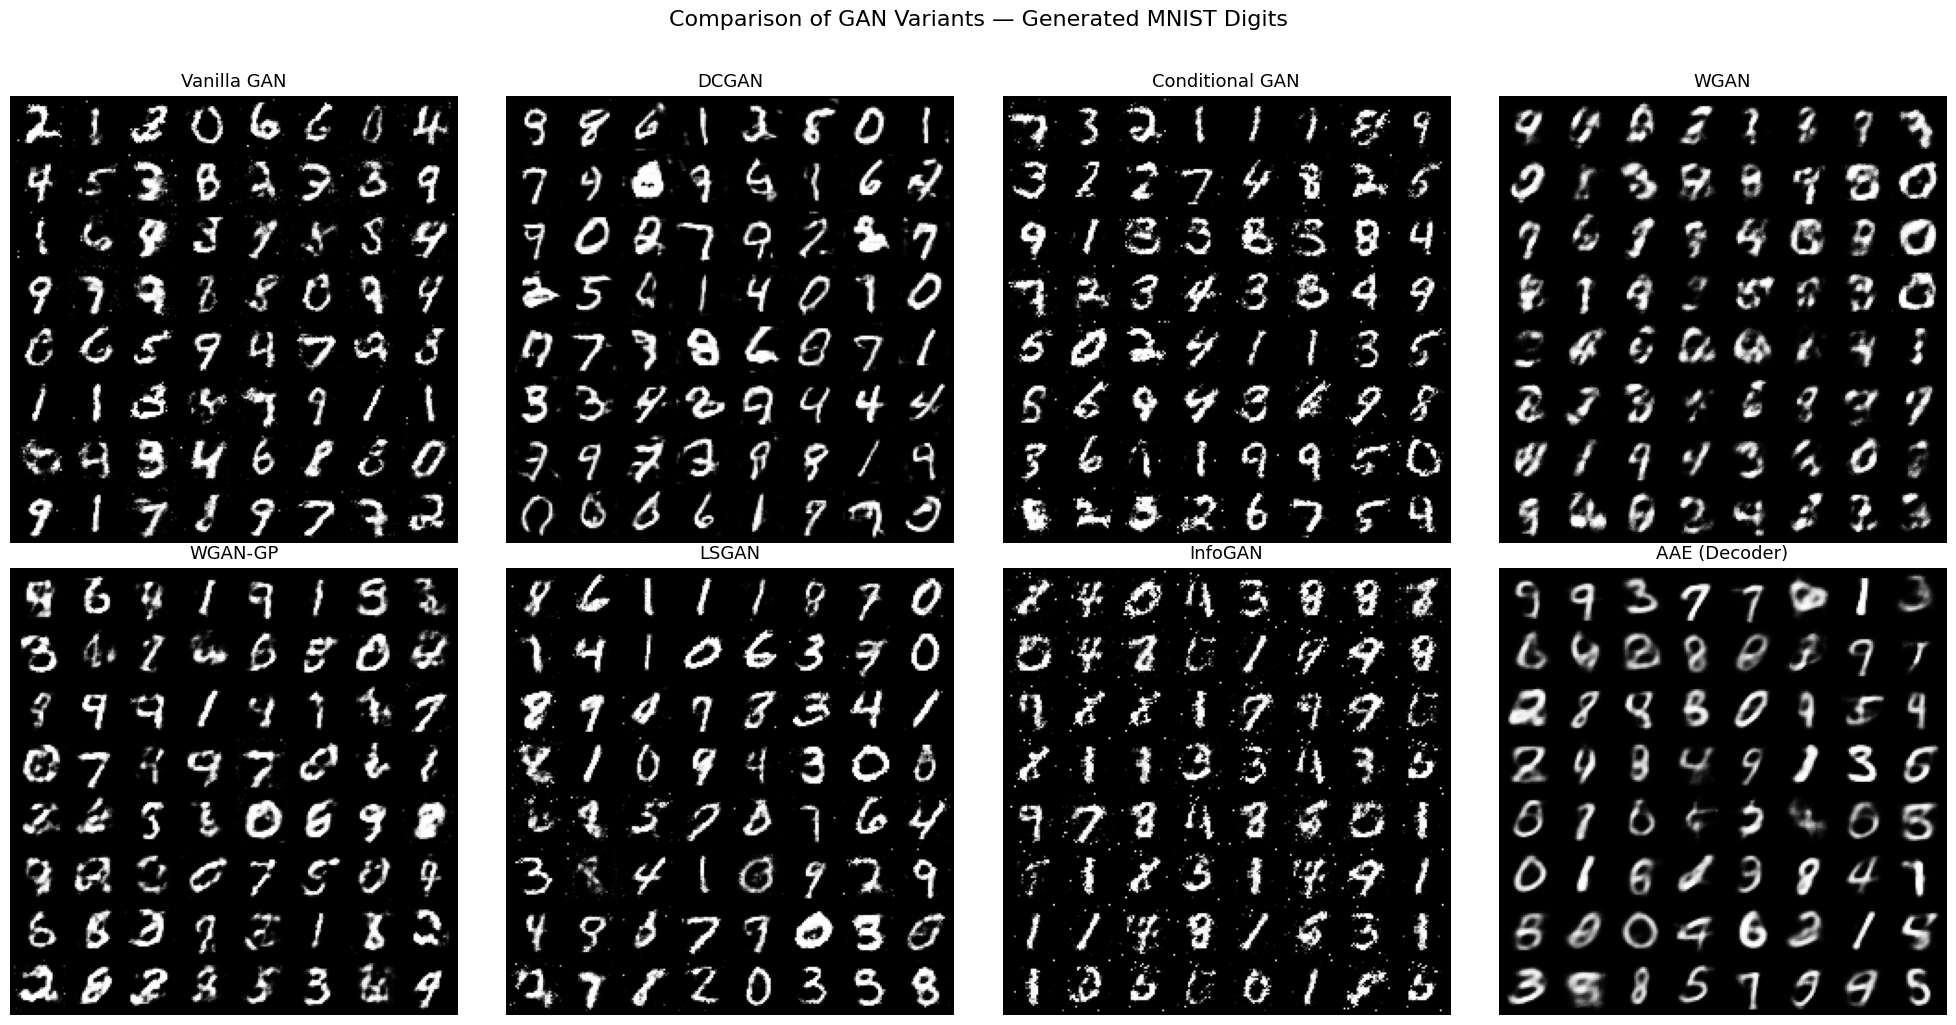

In [33]:
# Generate samples from all models for comparison
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Comparison of GAN Variants — Generated MNIST Digits", fontsize=16, y=1.02)

models = [
    ("Vanilla GAN", G_van, 'vanilla'),
    ("DCGAN", G_dc, 'dc'),
    ("Conditional GAN", G_cgan, 'cgan'),
    ("WGAN", G_wgan, 'wgan'),
    ("WGAN-GP", G_wgp, 'wgp'),
    ("LSGAN", G_ls, 'ls'),
    ("InfoGAN", G_info, 'info'),
    ("AAE (Decoder)", decoder, 'aae'),
]

for idx, (name, model, tag) in enumerate(models):
    row, col = idx // 4, idx % 4
    with torch.no_grad():
        if tag == 'cgan':
            z = torch.randn(64, LATENT_DIM, device=device)
            labels = torch.randint(0, 10, (64,), device=device)
            imgs = model(z, labels)
        elif tag == 'info':
            z = torch.randn(64, LATENT_DIM, device=device)
            c_cat = F.one_hot(torch.randint(0, 10, (64,), device=device), 10).float()
            c_cont = torch.randn(64, CODE_DIM, device=device) * 0.5
            imgs = model(z, c_cat, c_cont)
        elif tag == 'aae':
            z = torch.randn(64, AAE_LATENT_DIM, device=device)
            imgs = model(z)
        else:
            z = torch.randn(64, LATENT_DIM, device=device)
            imgs = model(z)

    imgs = (imgs.cpu() + 1) / 2
    grid = make_grid(imgs, nrow=8, padding=2)
    axes[row][col].imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    axes[row][col].set_title(name, fontsize=13)
    axes[row][col].axis('off')

plt.tight_layout()
plt.show()

---
# Summary

| GAN Variant | Key Innovation | Loss Type | Stability |
|---|---|---|---|
| **Vanilla GAN** | Original min-max game | BCE | Moderate |
| **DCGAN** | Convolutional architecture guidelines | BCE | Good |
| **Conditional GAN** | Class-conditioned generation | BCE | Good |
| **WGAN** | Wasserstein distance + weight clipping | Wasserstein | Better |
| **WGAN-GP** | Gradient penalty replaces clipping | Wasserstein + GP | Best |
| **LSGAN** | Least squares loss prevents vanishing gradients | MSE | Good |
| **InfoGAN** | Mutual information maximization for disentangled codes | BCE + Info | Moderate |
| **AAE** | GAN on latent space of autoencoder | Recon + BCE | Good |

**Key takeaways:**
- WGAN-GP generally provides the most stable training
- DCGAN's architectural guidelines improve quality over vanilla MLP-based GANs
- Conditional GAN and InfoGAN enable controllable generation
- AAE combines reconstruction quality with GAN-regularized latent spaces